# Neural Network model development
Created by Ivan Lima on Tue Oct  5 2021 10:07:34 -0400

In this notebook we experiment with different neural network configurations to predict DIC and TA from the merged bottle and satellite data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Mon Mar  7 17:02:12 2022


In [2]:
sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

In [3]:
# turn off GridSearchCV anoying warnings when n_jobs=-1
import sys, warnings
warnings.filterwarnings('ignore')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Examine the data

In [4]:
# read data
df = pd.read_csv('data/bottle_satellite_data_clean.csv', parse_dates=['Date'], index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3624 entries, 0 to 3779
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   EXPOCODE       2489 non-null   object        
 1   Accession      1124 non-null   float64       
 2   Cruise_ID      3045 non-null   object        
 3   Date           3624 non-null   datetime64[ns]
 4   Year           3624 non-null   int64         
 5   Month          3624 non-null   int64         
 6   Day            3624 non-null   int64         
 7   Time_UTC       3544 non-null   object        
 8   Latitude       3624 non-null   float64       
 9   Longitude      3624 non-null   float64       
 10  Depth          3624 non-null   float64       
 11  Salinity       3624 non-null   float64       
 12  Temperature    3624 non-null   float64       
 13  Oxygen         3534 non-null   float64       
 14  DIC            3624 non-null   float64       
 15  DIC_FLAG       3330 n

## Select input features and split data into training and test sets 

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Set input and output variables
features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave', 'SLA', 'SST_hires', 'log_KD490']
targets  = ['DIC', 'TA']

data = df[features + targets].dropna()

X = data[features].values
Y = data[targets].values

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

### Correlation between feature and target variables 

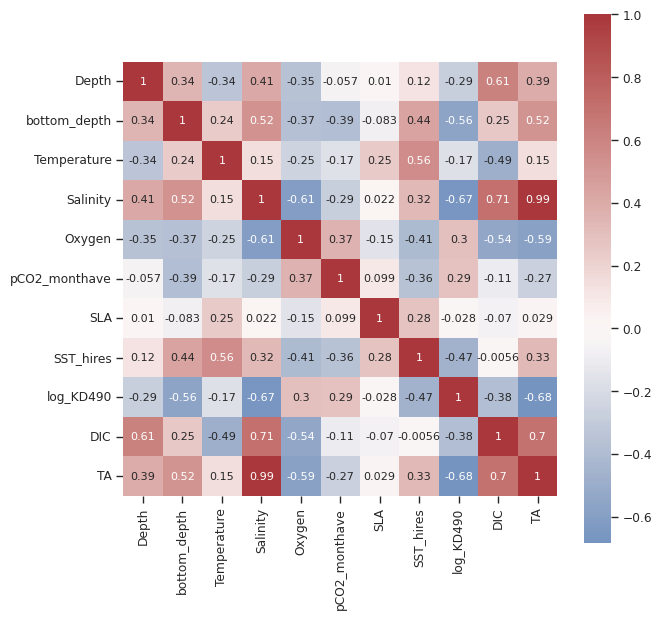

In [6]:
data = df[features + targets]
corr_mat = data.corr()
fig, ax = plt.subplots(figsize=(7,7))
_ = sns.heatmap(corr_mat, ax=ax, cmap='vlag', center=0, square=True, annot=True, annot_kws={'fontsize':8})

## Neural Network regression 

Linear models and neural networks are very tied to the scale and distribution of each feature. Therefore, we rescale input features so they have mean=0 and std=1.

Using log-transformed Chl and KD490 does not change training, test and generalization scores significantly.

Best cross-validation score: 0.974
Best parameters: {'mlpregressor__activation': 'logistic', 'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': [200]}
Best estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', alpha=0.01,
                              hidden_layer_sizes=[200], random_state=42,
                              solver='lbfgs'))])
Training set score: 0.978
Test set score:     0.970
Final model cross-validation mean score: 0.955


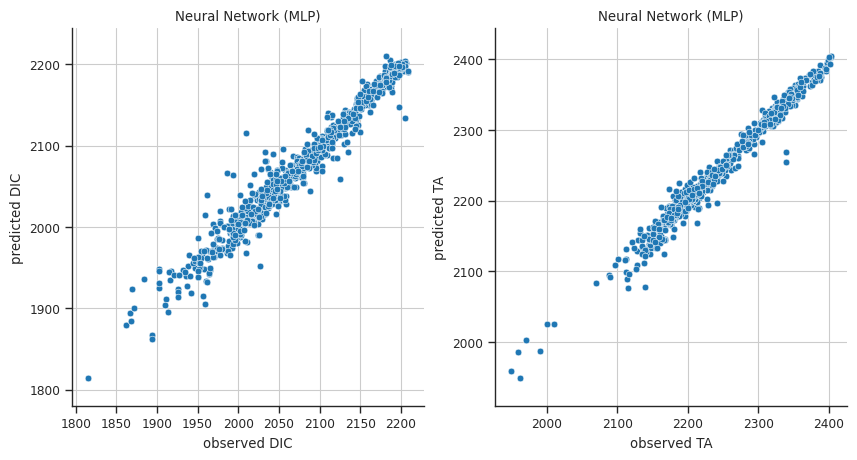

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline

pipe = make_pipeline(StandardScaler(), MLPRegressor(solver='lbfgs', random_state=42))

param_grid = {'mlpregressor__hidden_layer_sizes': [[100,], [200,], [300,], [400,]],
              'mlpregressor__activation' : ['logistic', 'tanh', 'relu'],
              'mlpregressor__alpha': [0.0001, 0.001, 0.01]}
gs_nnr = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gs_nnr.fit(X_train, Y_train);

print('Best cross-validation score: {:.3f}'.format(gs_nnr.best_score_))
print('Best parameters: {}'.format(gs_nnr.best_params_))
print('Best estimator: {}'.format(gs_nnr.best_estimator_))

print('Training set score: {:.3f}'.format(gs_nnr.score(X_train, Y_train)))
print('Test set score:     {:.3f}'.format(gs_nnr.score(X_test, Y_test)))

scores = cross_val_score(gs_nnr.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.3f}'.format(scores.mean()))

Y_pred = gs_nnr.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network (MLP)')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network (MLP)')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

#### Feature importance

A possible interpretation of the distribution of hidden node weights is that features that have small (absolute value) weights for all hidden nodes are less important to the model.

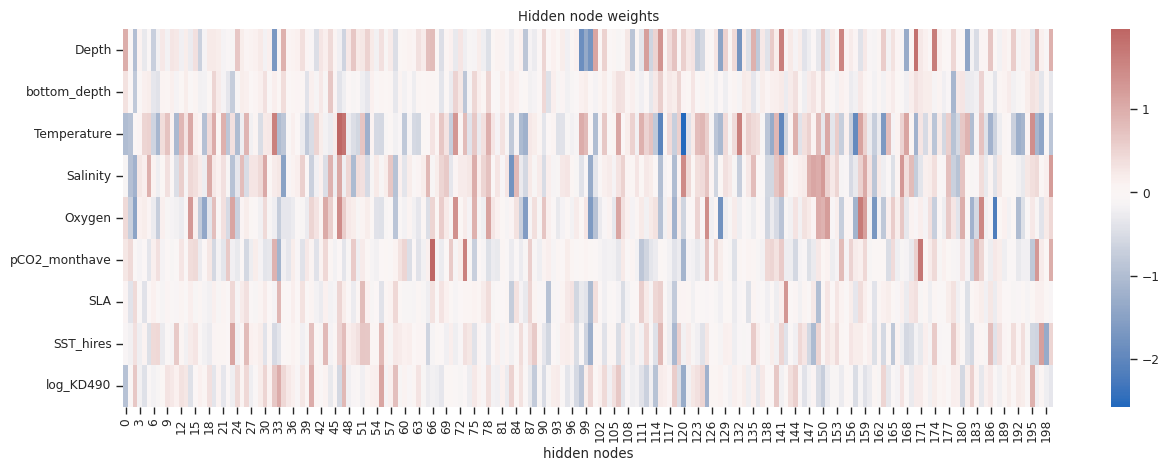

In [8]:
nn_weights = pd.DataFrame(gs_nnr.best_estimator_.named_steps['mlpregressor'].coefs_[0], index=features)
fig, ax = plt.subplots(figsize=(15, 5))
_ = sns.heatmap(nn_weights, center=0, cmap='vlag', ax=ax)
_ = ax.set(xlabel='hidden nodes', title='Hidden node weights')

#### Try different geometries (number of layers and nodes per layer)

In [9]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

mlp = MLPRegressor(activation='relu', hidden_layer_sizes=[100,200,100], random_state=42, solver='lbfgs')
nnr2 = mlp.fit(X_train_scaled, Y_train)

print('Training score: {:.3f}'.format(nnr2.score(X_train_scaled, Y_train)))
print('Test score:     {:.3f}'.format(nnr2.score(X_test_scaled, Y_test)))
scores = cross_val_score(nnr2, X_scaled, Y, cv=5, n_jobs=-1)
print('Cross-validation mean score: {:.3f}'.format(scores.mean()))

Training score: 0.971
Test score:     0.964
Cross-validation mean score: 0.953


In [10]:
pipe = make_pipeline(StandardScaler(), MLPRegressor(random_state=42))
param_grid = {'mlpregressor__hidden_layer_sizes': [[100,100], [100,200,200], [200,200]],
              'mlpregressor__activation' : ['logistic', 'tanh', 'relu'],
              'mlpregressor__solver': ['lbfgs', 'adam']}
gs_nnr3 = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gs_nnr3.fit(X_train, Y_train);

print('Best cross-validation score: {:.3f}'.format(gs_nnr3.best_score_))
print('Best parameters: {}'.format(gs_nnr3.best_params_))
print('Best estimator: {}'.format(gs_nnr3.best_estimator_))

print('Training set score: {:.3f}'.format(gs_nnr3.score(X_train, Y_train)))
print('Test set score:     {:.3f}'.format(gs_nnr3.score(X_test, Y_test)))

scores = cross_val_score(gs_nnr3.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.3f}'.format(scores.mean()))

Best cross-validation score: 0.970
Best parameters: {'mlpregressor__activation': 'relu', 'mlpregressor__hidden_layer_sizes': [100, 100], 'mlpregressor__solver': 'lbfgs'}
Best estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[100, 100], random_state=42,
                              solver='lbfgs'))])
Training set score: 0.972
Test set score:     0.964
Final model cross-validation mean score: 0.946
